# XGBoost

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Files
from util import fetchOnlineData, create_dataset
from indicators import get_indicators

sns.set(font_scale = 1.5)

## Initial variables

In [2]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Importing dataset

In [8]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=True)

[*********************100%***********************]  1 of 1 downloaded


# k-fold Cross Validation using XGBoost

In [293]:
# Create dataset
dataset = portf_value.copy()
dataset['date'] = portf_value.index
dataset.set_index('date', inplace=True)
dataset.rename(columns={'Adj Close': symbol}, inplace=True)

## Introduce the Predictor variables

In [294]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(dataset, symbol)


# Create momentum column
dataset['Momentum'] = sym_mom

# Create SMA column
dataset['RSI'] = rsi_value

# Clean nan values
dataset = dataset.fillna(0)

# Sort dataframe by index
dataset.sort_index()

date
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
2018-03-20    0.051882
2018-03-21    0.027507
2018-03-22   -0.015318
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
2018-04-04   -0.120779
2018-04-05   -0.111310
2018-04-06   -0.094140
2018-04-09   -0.062466
2018-04-10   -0.066350
2018-04-11   -0.033959
                ...   
2018-12-31   -0.065635
2019-01-02   -0.043109
2019-01-03   -0.060724
2019-01-04    0.017678
2019-01-07    0.051666
2019-01-08    0.096855
2019-01-09    0.129779
2019-01-10    0.089983
2019-01-11    0.084699
2019-01-14    0.067524
2019-01-15    0.083535
2019-01-16    0.111324
2019-0

,AABA,Momentum,RSI
date,,,
2018-02-13,71.309998,0.000000,89.590648
2018-02-14,73.660004,0.000000,89.590648
2018-02-15,74.400002,0.000000,89.590648
2018-02-16,73.510002,0.000000,89.590648
2018-02-20,74.589996,0.000000,89.590648
2018-02-21,75.110001,0.000000,89.590648
2018-02-22,75.519997,0.000000,89.590648
2018-02-23,77.760002,0.000000,92.027478
2018-02-26,78.080002,0.000000,92.326858


In [295]:
# Create dataset
dataset = portf_value.copy()
dataset['date'] = portf_value.index
dataset.set_index('date', inplace=True)
dataset.rename(columns={'Adj Close': symbol}, inplace=True)

## Introduce the Predictor variables

In [296]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(dataset, symbol)


# Create momentum column
dataset['Momentum'] = sym_mom

# Create SMA column
dataset['RSI'] = rsi_value

# Clean nan values
dataset = dataset.fillna(0)

# Sort dataframe by index
dataset.sort_index()

date
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
2018-03-20    0.051882
2018-03-21    0.027507
2018-03-22   -0.015318
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
2018-04-04   -0.120779
2018-04-05   -0.111310
2018-04-06   -0.094140
2018-04-09   -0.062466
2018-04-10   -0.066350
2018-04-11   -0.033959
                ...   
2018-12-31   -0.065635
2019-01-02   -0.043109
2019-01-03   -0.060724
2019-01-04    0.017678
2019-01-07    0.051666
2019-01-08    0.096855
2019-01-09    0.129779
2019-01-10    0.089983
2019-01-11    0.084699
2019-01-14    0.067524
2019-01-15    0.083535
2019-01-16    0.111324
2019-0

,AABA,Momentum,RSI
date,,,
2018-02-13,71.309998,0.000000,89.590648
2018-02-14,73.660004,0.000000,89.590648
2018-02-15,74.400002,0.000000,89.590648
2018-02-16,73.510002,0.000000,89.590648
2018-02-20,74.589996,0.000000,89.590648
2018-02-21,75.110001,0.000000,89.590648
2018-02-22,75.519997,0.000000,89.590648
2018-02-23,77.760002,0.000000,92.027478
2018-02-26,78.080002,0.000000,92.326858


## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [300]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
np_scaled = scaler.fit_transform(dataset)
dataset_normalized = pd.DataFrame(np_scaled)
dataset_normalized

,0,1,2
0,0.588148,0.473759,0.966046
1,0.675736,0.473759,0.966046
2,0.703317,0.473759,0.966046
3,0.670145,0.473759,0.966046
4,0.710399,0.473759,0.966046
5,0.729780,0.473759,0.966046
6,0.745061,0.473759,0.966046
7,0.828550,0.473759,0.996285
8,0.840477,0.473759,1.000000
9,0.767797,0.473759,0.758587


## Setup the Target variable or the desired output.

In [310]:
X, y = dataset_normalized.iloc[:,:-1], dataset_normalized.iloc[:,-1]

## Create XGBoost DMatrix structure

In [311]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [312]:
print(data_dmatrix.get_label())

[0.9660462  0.9660462  0.9660462  0.9660462  0.9660462  0.9660462
 0.9660462  0.99628496 1.         0.7585871  0.6329419  0.5369768
 0.45524022 0.5133017  0.6274953  0.67277825 0.6452064  0.70044106
 0.7523038  0.5674268  0.65012777 0.7605503  0.7802609  0.56939185
 0.6413869  0.5509197  0.32840666 0.26050526 0.45266888 0.32705298
 0.31134924 0.40708244 0.29711986 0.25621614 0.2191069  0.21373999
 0.14787614 0.23709735 0.42943573 0.41502416 0.4143122  0.3268334
 0.39147365 0.49997008 0.59462684 0.5625776  0.46403468 0.36333492
 0.31548712 0.24769406 0.42526248 0.41894805 0.45993257 0.43754613
 0.4820787  0.506774   0.73729265 0.85879433 0.88170874 0.8640198
 0.85851896 0.81185496 0.8689264  0.8062146  0.84157544 0.72956014
 0.61865455 0.72368485 0.6303265  0.6190537  0.6995201  0.7258193
 0.58797556 0.61998993 0.6389792  0.81914854 0.885909   0.8909404
 0.8727646  0.73617923 0.8047734  0.81567705 0.8786783  0.691653
 0.80951375 0.6500301  0.66402876 0.45313704 0.5594148  0.3941672
 0.3

## Create a hyper-parameter dictionary

We will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

In [313]:
params = {"objective":"reg:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10}

We will use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [314]:
cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=3,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123,)

[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:15:58] /workspace/sr

## cv_results contains train and test RMSE metrics for each boosting round.

In [315]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.227369,0.005571,0.227155,0.010842
1,0.227369,0.005571,0.227155,0.010842
2,0.227369,0.005571,0.227155,0.010842
3,0.226298,0.007085,0.226129,0.009391
4,0.224035,0.007680,0.224004,0.009089


## Extract and print the final boosting round metric.

In [316]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.197878
Name: test-rmse-mean, dtype: float64


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be around 6.02 per 1000$. 

You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters. 

## Instantiate an XGBoost regressor object

In [317]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:16:13] /workspace/sr

## Plotting the first tree

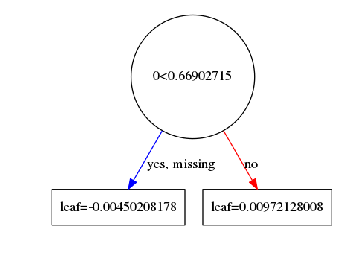

In [318]:
xgb.plot_tree(xg_reg,num_trees=1)
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Visualize your XGBoost models

It's to examine the importance of each feature column in the original dataset within the model.

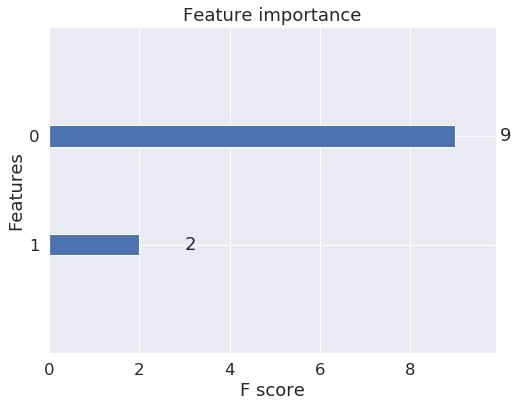

In [319]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

## Instantiate an XGBoost regressor object

## Split the data

In [322]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [323]:
xg_reg = xgb.XGBRegressor(**params)

## Fit the regressor to the training set

In [324]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Make predictions on the test set

In [325]:
preds = xg_reg.predict(X_test)

## Compute the rmse

In [326]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.161594


## Plotting

In [327]:
# standardize the data attributes
standardized_X = preprocessing.scale(y_test)

In [328]:
predictions = pd.DataFrame({'Price': y_test, 'Price prediction': preds})

# Order dataframe
predictions.sort_index(inplace=True)

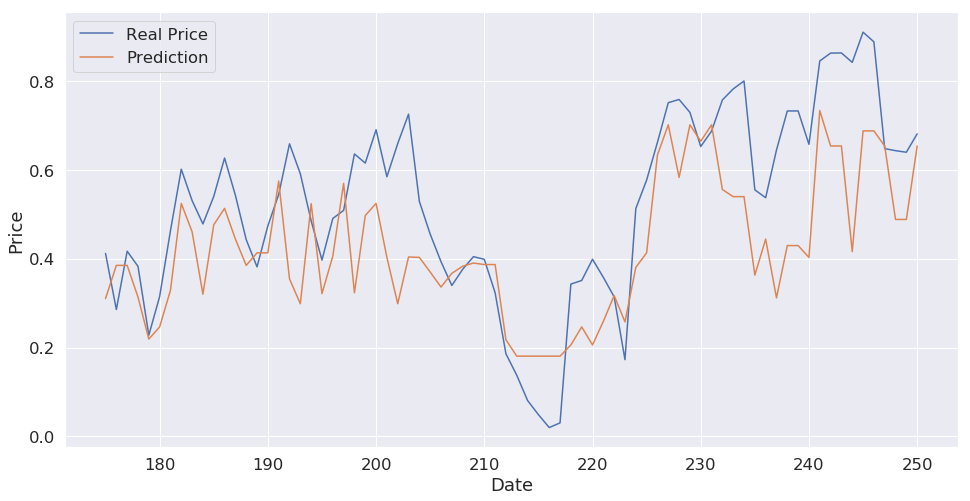

In [329]:
plt.figure(figsize=(16,8))
plt.plot(predictions)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()